In [1]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from PIL import *
import cv2

import time
import math

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

from pangu_dataset_mask import CraterDataset


In [2]:

autoreload 2

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200

In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / 1024 ** 2
print('model size: {:.3f}MB'.format(size_all_mb))

/home/sofia/miniconda3/envs/pyenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sofia/miniconda3/envs/pyenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model size: 168.043MB


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [7]:
path = "training_checkpoints/mask_rcnn_1.blob"
# path = "training_checkpoints_fewer_craters/mask_rcnn_6.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

/tmp/ipykernel_2562/2143274657.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( path ) )


Loaded: training_checkpoints/mask_rcnn_1.blob


In [8]:
# Load Robins crater database:
craters = pd.read_csv( '../data/craters_with_stats_-90_-45_0_90.csv' ).dropna()
craters = craters.loc[:, ~craters.columns.str.contains('^Unnamed')]
craters['medianDifference'] = ( craters['rimMedian'] - craters['fullMedian'] ).abs()


# Build CDA database (typically takes about a minute)
img_size = (1024, 1024)
root_dir = "../data/"
# ldem_name = "LDEM_-90_-45E_0_45N"
ldem_name = "LDEM_-90_-45E_0_45N_all_ellipses"
# ldem_name = "LDEM_-90_-45E_0_45N_float_60fov_1024_1024_20deg_off_nadir"
min_angle = 20
max_angle = 70 # 70 make it one more than what's avaliable
angle_inc = 5

# Limit number of craters per image (sorted from largest projected ellipse semi minor axis)
# If you want to use all filtered craters, set max_number_craters = -1

cd = CraterDataset(craters, img_size, root_dir, ldem_name, min_angle, max_angle, angle_inc, None, True, True)


# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )




# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_train = torch.utils.data.Subset( cd, trainIndices )
dataset_test = torch.utils.data.Subset( cd, testIndices )

# define training and validation data loaders
### (Sofia): data loaders do a lot of useful things on their own.
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 8,
    shuffle = True,
    num_workers = 16,
    collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 4,
    shuffle = False,
    num_workers = 8,
    collate_fn = collate_fn
)





import gc
# Test version
predictions = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )

        # Make predictions
        p = model( images )

        # Move predictions to RAM
        p = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in p ]

        # Postprocess mask into ellipse parameters
        for sample in p:
            sample['ellipse_sparse'] = []

            for im in sample['masks']:
                im = im.numpy()[0]
                im = np.array( np.round( im ), dtype = np.uint8 )
                threshold = 0.5
                canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
                contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 
                
                for contour in contours:
                    # Hopefully only ever one!
                    if contour.shape[0] > 5:
                        e = cv2.fitEllipse( contour )
                        sample['ellipse_sparse'].append( [ e[0][0], e[0][1], e[1][0], e[1][1], e[2] * math.pi / 180 ] )
                    break
            # Delete masks from prediction to save memory
            del sample['masks']
        
        predictions.extend( p )
        gc.collect()

# Show a random sample of predictions
n_samples = 2
fig, ax = plt.subplots( ncols = n_samples )

pred_threshold = 0.7


for i in range( n_samples ):
    test_set_index = int( np.random.rand() * len( testIndices ) )
    dataset_index = testIndices[test_set_index]
    img, target = cd.__getitem__( dataset_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )
    
    # Apply prediction confidence mask
    mask = predictions[test_set_index]['scores'] > 0.7
    mask = np.array(mask)
    print(predictions[test_set_index]['scores'])
    
    # ground truth
    img = plot_masks( img, target['boxes'], target['masks'], color = ( 0, 1, 0 ), color_channel = 1, plot_box = False, plot_mask = False, plot_ellipse = True)

    # print(len(predictions[test_set_index]['boxes']))
    # print(len(mask))
    # print(np.array(predictions[test_set_index]['ellipse_sparse'])[mask])
    # # predicted
    # print(np.array(predictions[test_set_index]['ellipse_sparse'])[mask])
    # print(len(np.array(predictions[test_set_index]['ellipse_sparse'])))
    # print(len(np.array(mask)))
    # print(np.array(predictions[test_set_index]['ellipse_sparse']))
    # print(mask)
    img = plot_ellipses( img, predictions[test_set_index]['boxes'][mask], np.array(predictions[test_set_index]['ellipse_sparse'])[mask], color = ( 1, 0, 0 ), plot_boxes=False )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
    
plt.show()


Filter bad samples:


KeyboardInterrupt: 

In [8]:
# Load Robins crater database:
craters = pd.read_csv( '../data/craters_with_stats_-90_-45_0_90.csv' ).dropna()
craters = craters.loc[:, ~craters.columns.str.contains('^Unnamed')]
craters['medianDifference'] = ( craters['rimMedian'] - craters['fullMedian'] ).abs()

In [9]:
# Build CDA database (typically takes about a minute)
img_size = (1024, 1024)
root_dir = "../data/"
ldem_name = "LDEM_-90_-45E_0_45N_all_ellipses"
# ldem_name = "LDEM_-90_-45E_0_45N_float_60fov_1024_1024_20deg_off_nadir"
min_angle = 20
max_angle = 70
angle_inc = 5


# Limit number of craters per image (sorted from largest projected ellipse semi minor axis)
# If you want to use all filtered craters, set max_number_craters = -1


cd = CraterDataset(craters, img_size, root_dir, ldem_name, min_angle, max_angle, angle_inc, None, True, True)

Filter bad samples:
Total Images after Filtering 2410


In [10]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )

In [11]:
# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_train = torch.utils.data.Subset( cd, trainIndices )
dataset_test = torch.utils.data.Subset( cd, testIndices )

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 8,
    shuffle = True,
    num_workers = 16,
    collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 8,
    shuffle = False,
    num_workers = 16,
    collate_fn = collate_fn
)

Training samples: 916
Testing samples: 307


In [12]:
predictions = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )

        # Make predictions
        p = model( images )

        # Move predictions to RAM
        p = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in p ]

        # Postprocess mask into ellipse parameters
        for sample in p:
            sample['ellipse_sparse'] = []

            for im in sample['masks']:
                im = im.numpy()[0]
                im = np.array( np.round( im ), dtype = np.uint8 )
                threshold = 0.5
                canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
                contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 
                
                for contour in contours:
                    # Hopefully only ever one!
                    if contour.shape[0] > 5:
                        e = cv2.fitEllipse( contour )
                        sample['ellipse_sparse'].append( [ e[0][0], e[0][1], e[1][0], e[1][1], e[2] * math.pi / 180 ] )
                    break
            # Delete masks from prediction to save memory
            del sample['masks']
        
        predictions.extend( p )

Test Predictions: 100%|██████████| 39/39 [03:30<00:00,  5.40s/it]


In [13]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        # targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']
        
        targets.extend( targets_batch )

Test Predictions:   0%|          | 0/39 [00:00<?, ?it/s]

Test Predictions: 100%|██████████| 39/39 [00:04<00:00,  8.74it/s]


In [16]:
from joblib import dump
dump( { 'targets': targets, 'predictions': predictions }, 'Mask-Sim-Test' )

['Mask-Sim-Test']

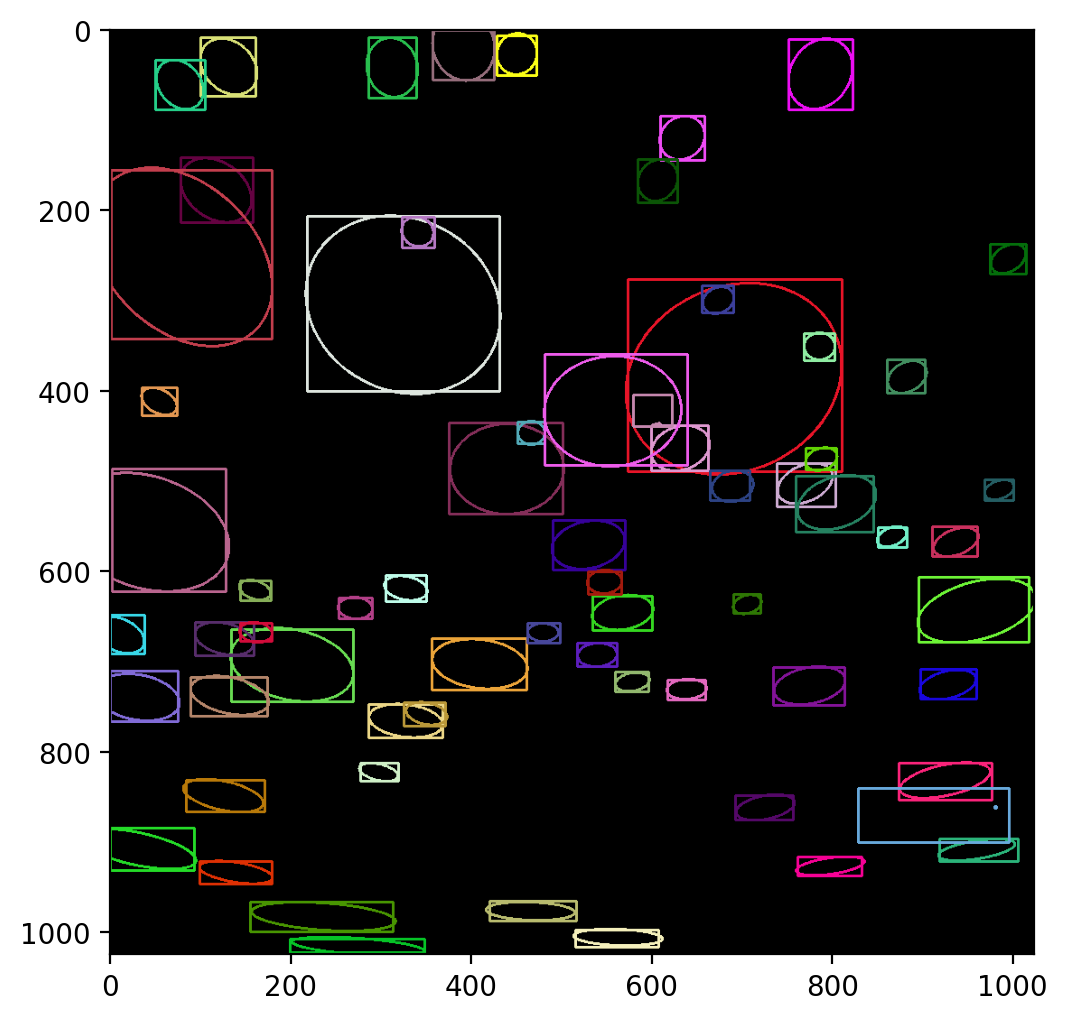

In [17]:
img = np.zeros( ( 1024, 1024, 3 ) )

# for bbox, mask in zip( p[0]['boxes'].numpy(), p[0]['masks'].numpy() ):
for bbox, ellipse in zip( p[0]['boxes'].numpy(), p[0]['ellipse_sparse'] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )
    x,y,a,b,theta = ellipse
    theta *= 180/math.pi
    cv2.ellipse( 
            img,
            ( int(x), int(y) ), # Center point
            ( int(a/2), int(b/2) ), # Major and minor axes
            theta, # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )
    # Apply color to mask
    # mask = cv2.merge( ( mask * color[0], mask * color[1], mask * color[2] ) )
    # img[:,:,:] += mask[0]
    
plt.imshow( img )
plt.show()

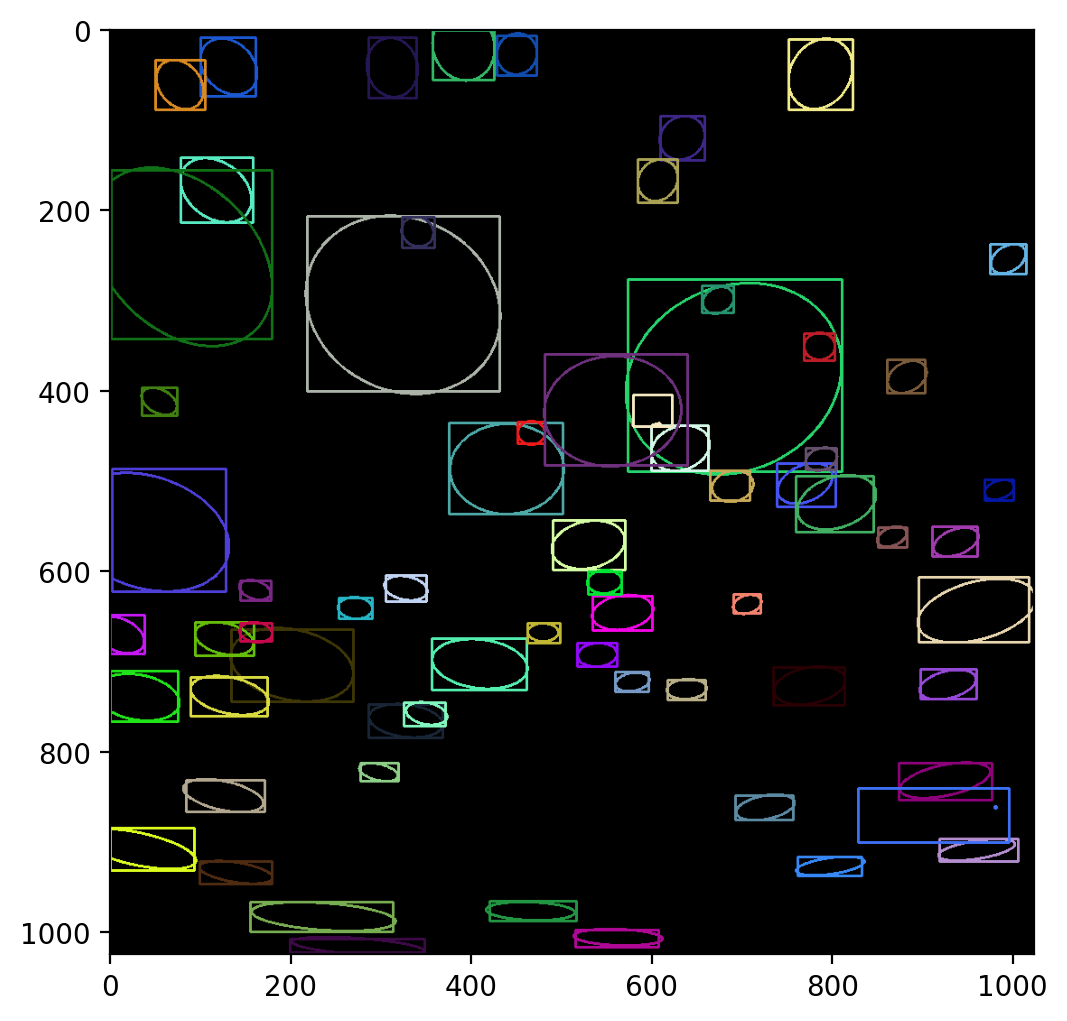

In [18]:
img = np.zeros( ( 1024, 1024, 3 ) )

index = 0

ellipses_from_contour = []

for bbox, ellipse in zip( p[index]['boxes'].numpy(), p[index]['ellipse_sparse']):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )
    x,y,a,b,theta = ellipse
    theta *= 180/math.pi
    cv2.ellipse( 
            img,
            ( int(x), int(y) ), # Center point
            ( int(a/2), int(b/2) ), # Major and minor axes
            theta, # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    # # Fit ellipse
    # im = mask[0]
    # im = np.array( np.round( im ), dtype = np.uint8 )
    # threshold = 0.5
    # canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
    # contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 

    # # print( contours[0].shape )
    # # print( contours[1].shape )
    
    # for contour in contours:
    #     # Hopefully only ever one!
    #     if contour.shape[0] > 5:
    #         e = cv2.fitEllipse( contour )
    #         ellipses_from_contour.append( e )
            
    #         cv2.ellipse( 
    #             img,
    #             ( int( e[0][0] ), int( e[0][1] ) ), # Center point
    #             ( int( e[1][0] / 2 ), int( e[1][1] / 2 ) ), # Major and minor axes
    #             float( e[2] ), # Convert angle from radians to degrees
    #             0, # Start Angle for drawing
    #             360, # End Angle for drawing
    #             color,
    #             2,
    #         )
    #     break
    
plt.imshow( img )
plt.show()

In [19]:
print( len( p[index]['boxes'].numpy() ) )
print( len( p[index]['ellipse_sparse'] ) )

print( len( ellipses_from_contour ) )

67
67
0


In [20]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        # targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']
        
        targets.extend( targets_batch )
        
# targets = []

# with torch.no_grad():
#     bar = tq( data_loader_test, desc = f"Test Predictions" )
    
#     for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
#         targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

#         # Delete masks from target to save memory
#         for t in targets_batch:
#             del t['masks']
        
#         targets.extend( targets_batch )

Test Predictions: 100%|██████████| 39/39 [00:04<00:00,  8.63it/s]


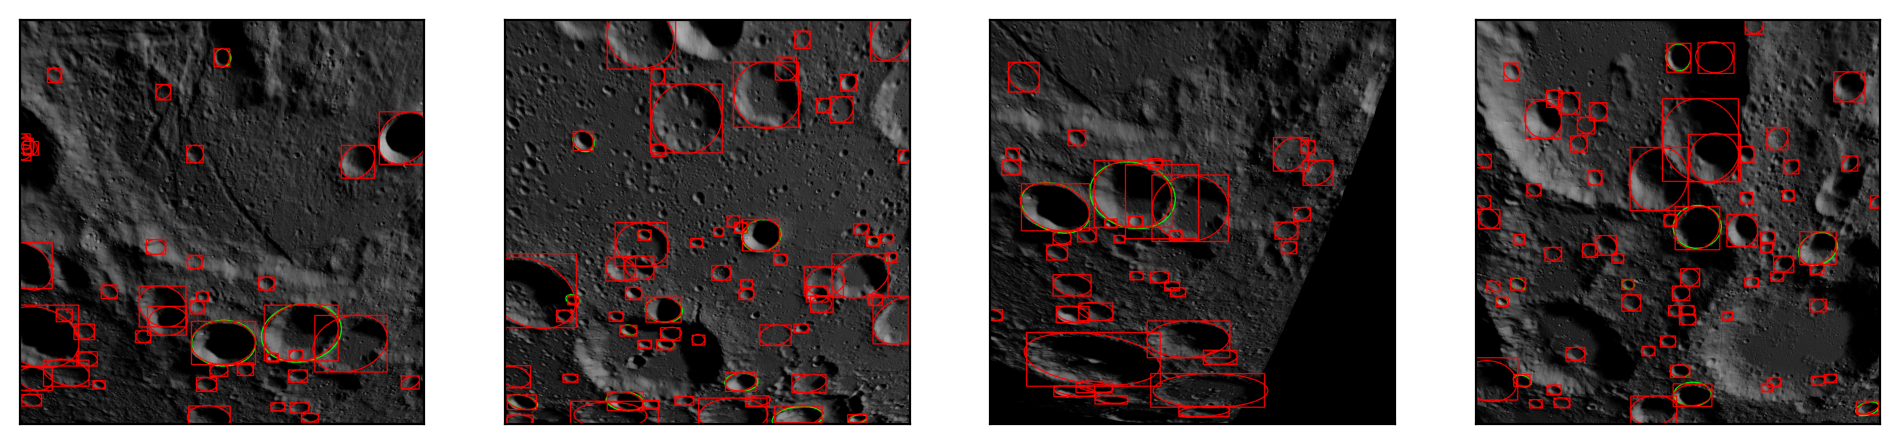

In [21]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    color = ( 0, 1, 0 )
    for ellipse in target['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] ), int( ellipse[3] ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    color = ( 1, 0, 0 )
    for ellipse in predictions[pred_index]['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] / 2 ), int( ellipse[3] / 2 ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    for bbox in predictions[pred_index]['boxes']:
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            (1,0,0),
            2,
        )

    # Red is False Negative
    # Green is False Positive
    # Yellow is True Positive
    
    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [21]:
results = []

for confidence_threshold in np.concatenate( ( np.arange( 0.01, 0.1, 0.01 ), np.arange( 0.1, 0.9, 0.1 ), np.arange( 0.9, 1.0, 0.01 ) ), axis = 0 ):
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()
        
        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
        } )

    for IoU_threshold in np.arange( 0.5, 1, 0.05 ):
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for pred, target in zip( confident_predictions, targets ):
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold

                tp += iou_masked.any( axis = 0 ).sum()
                true_boxes += iou_masked.shape[1]
                pred_boxes += iou_masked.shape[0]

        results.append( {
            'detections_per_image': tp.item() / len( targets ),
            'confidence_threshold': confidence_threshold,
            'IoU_threshold': IoU_threshold,
            'precision': ( tp / pred_boxes ).item(),
            'recall': ( tp / true_boxes ).item()
        } )
        # 'detections_per_image': tp.item() / len( targets ),

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [22]:
results = pd.DataFrame( results )
results['f1_score'] = ( 2 * results['precision'] * results['recall'] ) / ( results['precision'] + results['recall'] )

print( 'Performance where F1 score was maximised:' )
print( results.iloc[results['f1_score'].argmax()] )

display( results )

Performance where F1 score was maximised:
detections_per_image    8.198697
confidence_threshold    0.800000
IoU_threshold           0.500000
precision               0.910307
recall                  0.867632
f1_score                0.888457
Name: 160, dtype: float64


,detections_per_image,confidence_threshold,IoU_threshold,precision,recall,f1_score
0,8.912052,0.01,0.50,0.742067,0.943123,0.830601
1,8.912052,0.01,0.55,0.742067,0.943123,0.830601
2,8.908795,0.01,0.60,0.741795,0.942778,0.830297
3,8.899023,0.01,0.65,0.740982,0.941744,0.829387
4,8.876221,0.01,0.70,0.739083,0.939331,0.827262
...,...,...,...,...,...,...
265,6.703583,0.99,0.75,0.974432,0.709411,0.821065
266,6.693811,0.99,0.80,0.973011,0.708376,0.819868
267,6.563518,0.99,0.85,0.954072,0.694588,0.803910
268,6.065147,0.99,0.90,0.881629,0.641848,0.742869


In [23]:
best_confidence_threshold = 0.7

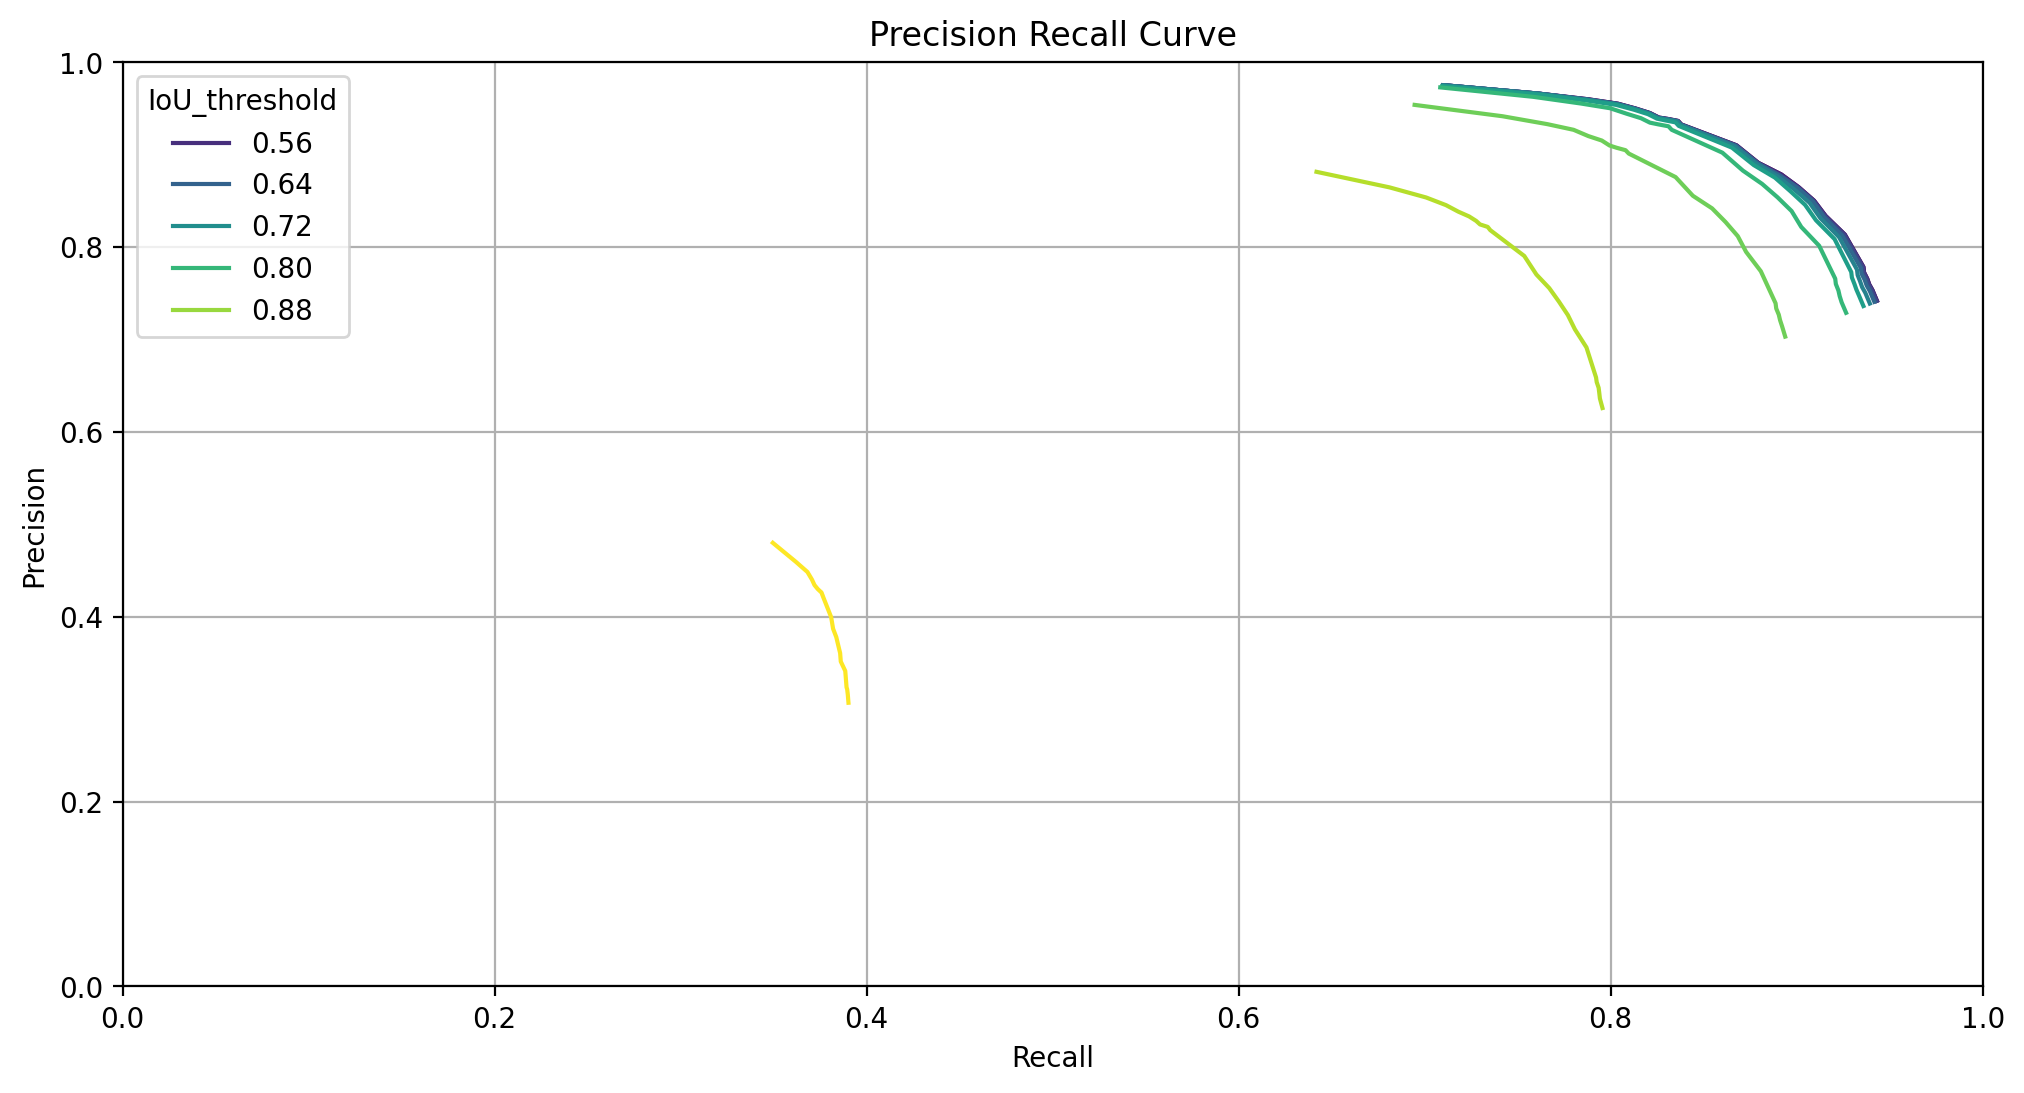

In [24]:
sns.lineplot(
    data = results,
    x = 'recall',
    y = 'precision',
    hue = 'IoU_threshold',
    # hue = 'confidence_threshold',
    palette = 'viridis',
)
plt.title( 'Precision Recall Curve')
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.ylim( 0, 1 )
plt.xlim( 0, 1 )
plt.grid()
plt.show()

In [25]:
from pangu_dataset_mask import evaluate_ellipse

In [26]:
ellipse_matches = []

confidence_thresholds = [ best_confidence_threshold ]
IoU_thresholds = [ 0.5 ]

for confidence_threshold in confidence_thresholds:
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()

        # Process ellipses
        e = np.array( prediction['ellipse_sparse'] )[indices]
        e[:,2] /= 2
        e[:,3] /= 2

        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
            'ellipse_sparse': e,
        } )
    
    for IoU_threshold in IoU_thresholds:
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for i, ( pred, target ) in enumerate( zip( confident_predictions, targets ) ):
            print( i, end = '\r' )
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold
                indices = ( iou_masked == True ).nonzero( as_tuple = True )

                for pred_index, true_index in zip( indices[0], indices[1] ):
                    error = evaluate_ellipse(
                        pred['ellipse_sparse'][pred_index],
                        target['ellipse_sparse'][true_index].to( 'cpu' ).numpy()
                    )
                    
                    ellipse_matches.append( {
                        'confidence_threshold': confidence_threshold,
                        'IoU_threshold': IoU_threshold,
                        # 'view_angle': target['view_angle'].to( 'cpu' ).numpy()[0],
                        # 'depth': target['depths'][true_index].to( 'cpu' ).numpy(),
                        'pred': pred['ellipse_sparse'][pred_index],
                        'target': target['ellipse_sparse'][true_index].to( 'cpu' ).numpy(),
                    } | error )

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [27]:
ellipse_matches = pd.DataFrame( ellipse_matches )
display( ellipse_matches )

,confidence_threshold,IoU_threshold,pred,target,x_error,y_error,a_error,b_error,theta_error,absolute_error,IoU
0,0.7,0.5,"[93.38868713378906, 853.7284545898438, 25.8372...","[94.563126, 855.0782, 37.236214, 26.377253, 0....",1.174438,1.349731,11.398973,11.091105,1.492152,26.506400,0.907274
1,0.7,0.5,"[244.1162109375, 705.216552734375, 45.02276229...","[245.47446, 706.59094, 57.94936, 46.782913, 0....",1.358246,1.374390,12.926598,11.327927,1.589003,28.576163,0.960830
2,0.7,0.5,"[216.58938598632812, 786.0706787109375, 14.231...","[217.30725, 786.8506, 18.702614, 14.355023, 0....",0.717865,0.779907,4.471044,4.305923,1.433594,11.708333,0.923429
3,0.7,0.5,"[457.53021240234375, 721.0064697265625, 20.871...","[458.5061, 721.4696, 24.25878, 20.251266, 0.07...",0.975891,0.463135,3.387175,4.184654,1.510139,10.520993,0.952322
4,0.7,0.5,"[187.69467163085938, 957.4677124023438, 24.232...","[188.90773, 957.07025, 34.42037, 23.430016, 0....",1.213058,0.397461,10.187483,9.918194,1.530108,23.246304,0.945524
...,...,...,...,...,...,...,...,...,...,...,...
2546,0.7,0.5,"[271.21588134765625, 677.8878173828125, 30.245...","[269.1861, 677.9213, 56.539032, 31.082777, 0.1...",2.029785,0.033508,26.293566,26.372984,1.541957,56.271800,0.938408
2547,0.7,0.5,"[485.3468017578125, 327.2752990722656, 118.015...","[486.92368, 325.7369, 133.38838, 117.25243, 0....",1.576874,1.538391,15.372810,17.368019,1.661036,37.517130,0.968107
2548,0.7,0.5,"[829.7079467773438, 701.455078125, 22.95622253...","[829.60724, 702.299, 45.135445, 22.881008, -0....",0.100708,0.843933,22.179222,21.661083,1.684511,46.469457,0.879953
2549,0.7,0.5,"[919.3016967773438, 694.9473876953125, 16.8456...","[919.2237, 695.4499, 32.7636, 15.862438, -0.26...",0.078003,0.502502,15.917984,18.127026,1.598996,36.224511,0.907418


In [28]:
predicted_ellipses = pd.DataFrame( ellipse_matches['pred'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )
true_ellipses = pd.DataFrame( ellipse_matches['target'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )

In [29]:
ellipse_matches['eccentricity'] = true_ellipses['b'] / true_ellipses['a']

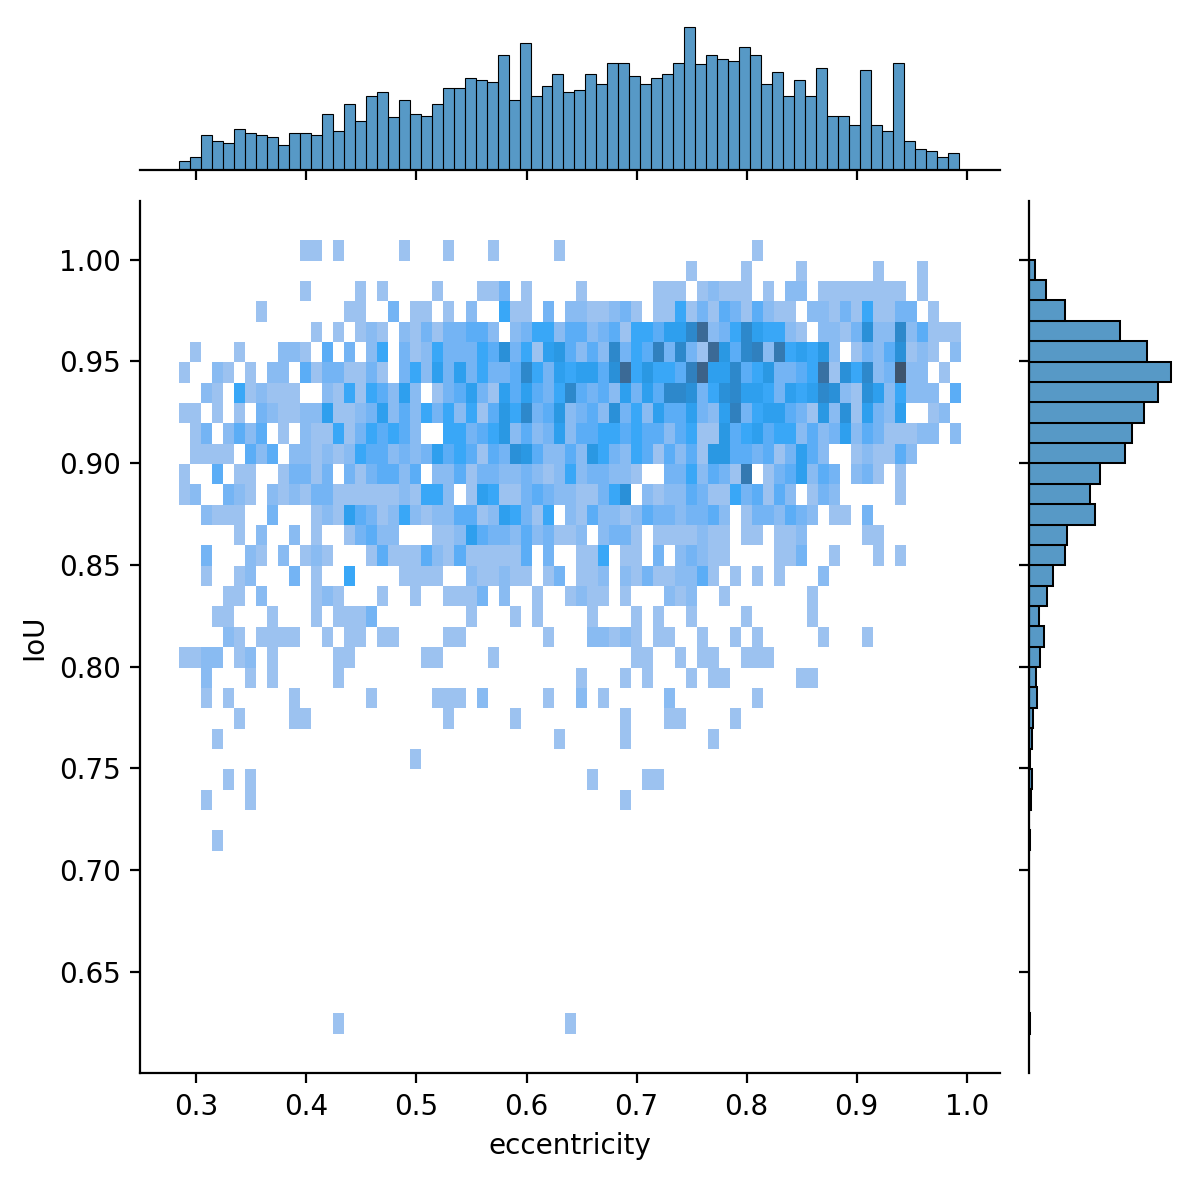

In [30]:
p = sns.jointplot(
    ellipse_matches,
    y = 'IoU',
    x = 'eccentricity',
    kind = 'hist',
    # alpha = 0.4,
    binwidth = ( 0.01, 0.01 ),
    # hue_norm = 'log',
)

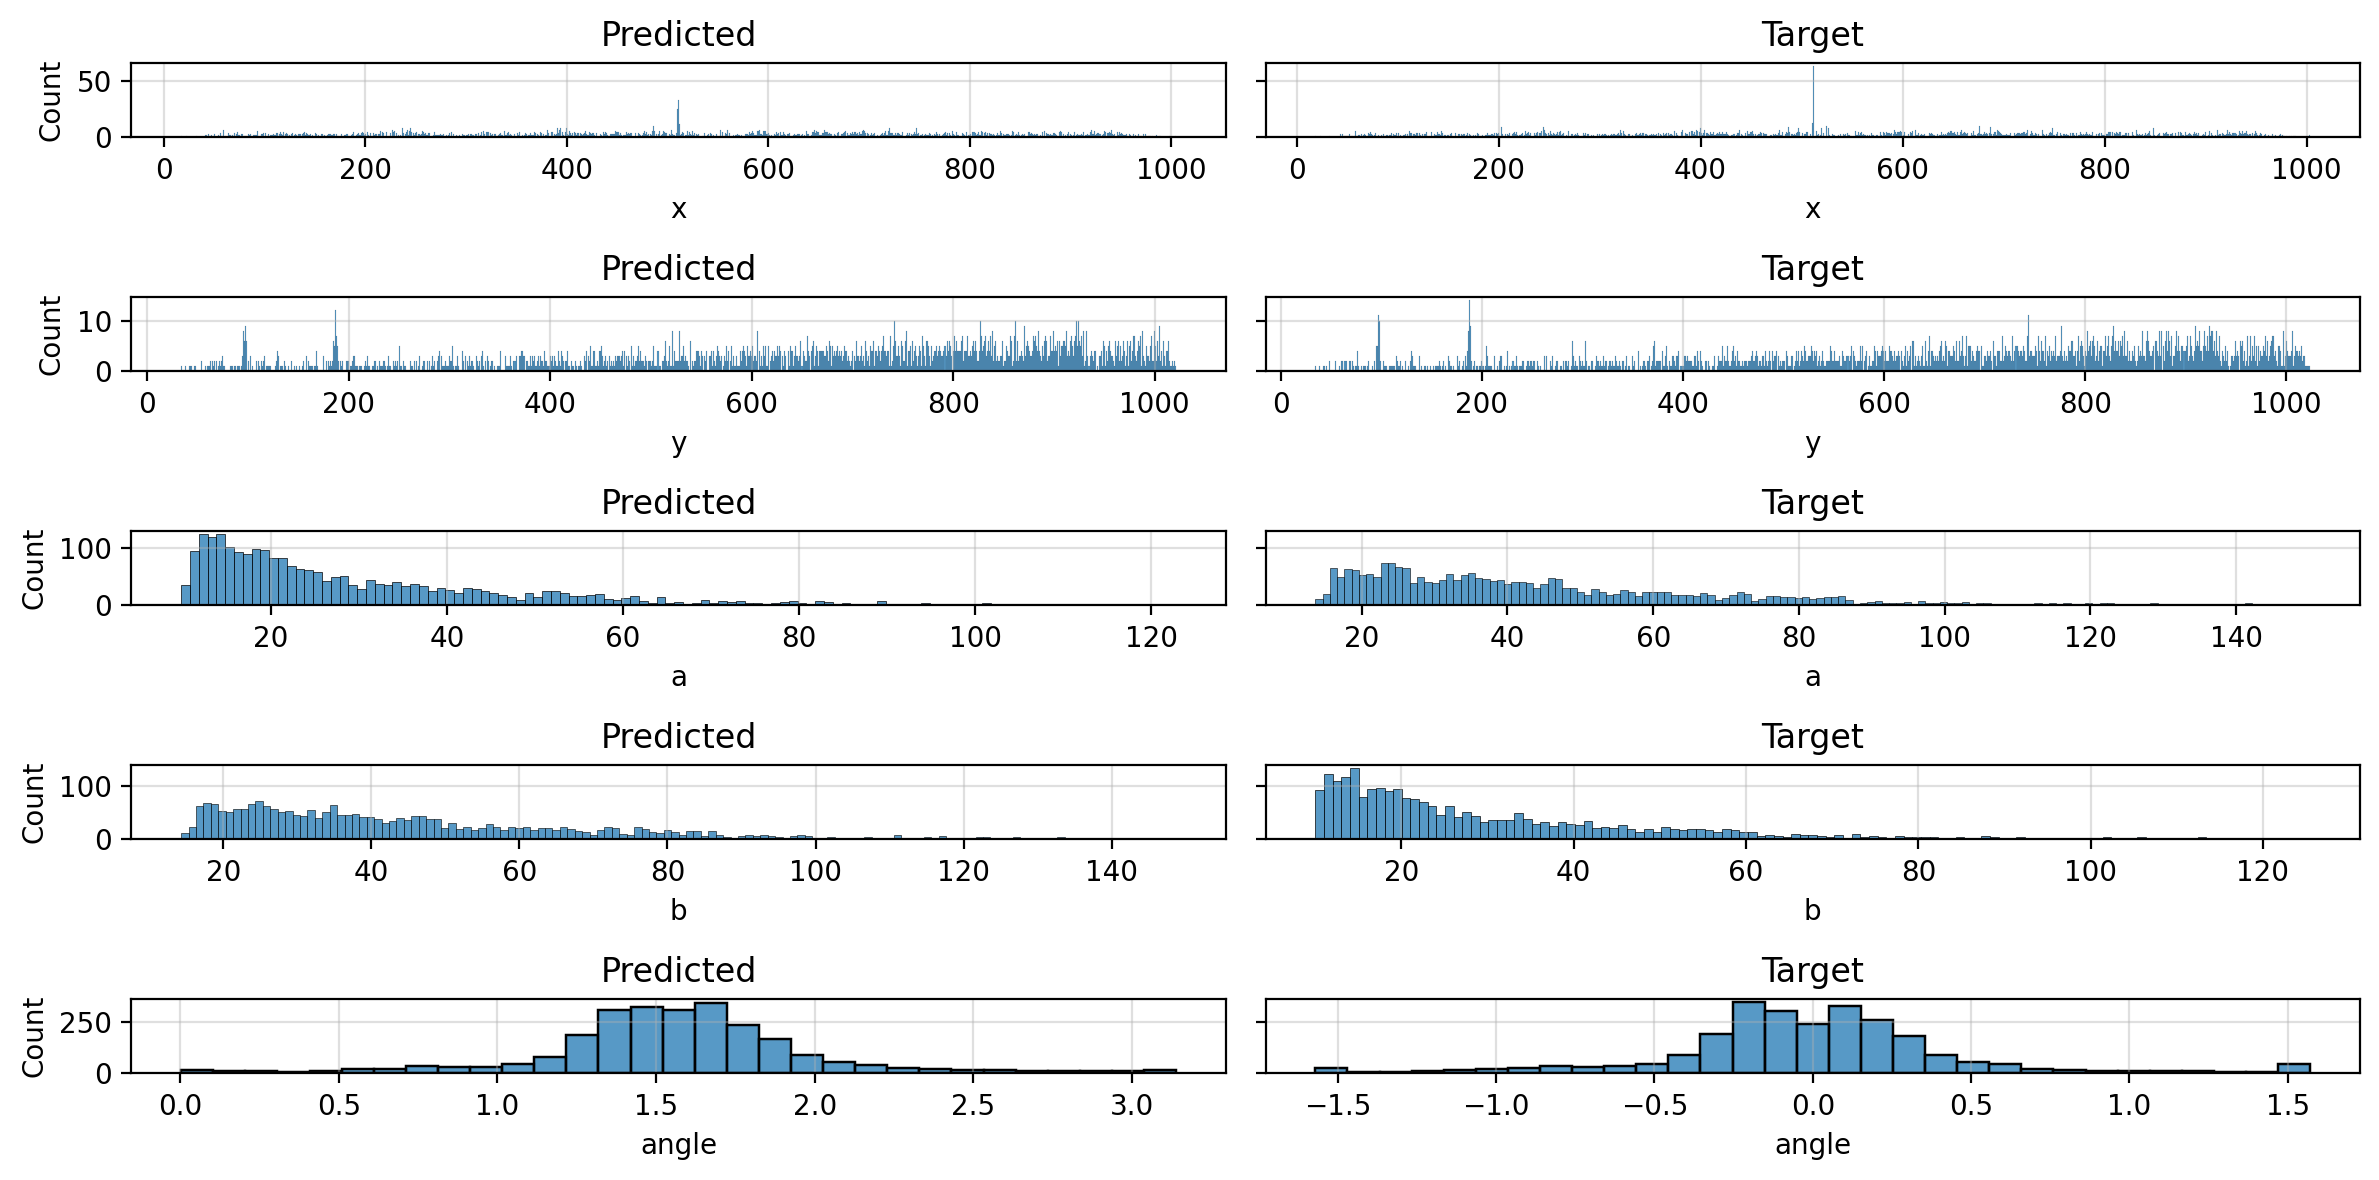

In [31]:
# Compare distribution of predicted and target ellipses
keys = [ 'x', 'y', 'a', 'b', 'angle' ]
bin_widths = [ 1, 1, 1, 1, 0.1 ]

fig, ax = plt.subplots( nrows = len( keys ), ncols = 2, sharey = 'row', figsize = ( 12, 6 ) )

for i, key in enumerate( keys ):
    p = sns.histplot(
        data = predicted_ellipses,
        ax = ax[i,0],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Predicted' )
    p.set_xlabel( key )
    
    p = sns.histplot(
        data = true_ellipses,
        ax = ax[i,1],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Target' )
    p.set_xlabel( key )

fig.tight_layout()
plt.show()

In [52]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error', 'IoU' ]

print( 'Average error in matched ellipses' )
for key in keys:
    print( key, ':', round( ellipse_matches[key].mean(), 3 ) )

Average error in matched ellipses
x_error : 0.928
y_error : 0.98
a_error : 14.961
b_error : 15.701
theta_error : 1.601
absolute_error : 34.171
IoU : 0.915


In [ ]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error', 'gaussian_angle', 'kl_divergence', 'IoU' ]
bin_widths = [ 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ]
xlims = [ 20, 20, 20, 20, math.pi, 100, 1.7, 1.1, 1.1 ]

for e in ellipse_matches:
    print(e)

for i, key in enumerate( keys ):
    p = sns.histplot(
        data = ellipse_matches,
        x = key,
        binwidth = bin_widths[i],
    )
    p.set_xlim( 0, xlims[i] )
    p.grid( alpha = 0.4 )
    plt.show()

      confidence_threshold  IoU_threshold  \
0                      0.7            0.5   
1                      0.7            0.5   
2                      0.7            0.5   
3                      0.7            0.5   
4                      0.7            0.5   
...                    ...            ...   
2546                   0.7            0.5   
2547                   0.7            0.5   
2548                   0.7            0.5   
2549                   0.7            0.5   
2550                   0.7            0.5   

                                                   pred  \
0     [93.38868713378906, 853.7284545898438, 25.8372...   
1     [244.1162109375, 705.216552734375, 45.02276229...   
2     [216.58938598632812, 786.0706787109375, 14.231...   
3     [457.53021240234375, 721.0064697265625, 20.871...   
4     [187.69467163085938, 957.4677124023438, 24.232...   
...                                                 ...   
2546  [271.21588134765625, 677.8878173828125, 

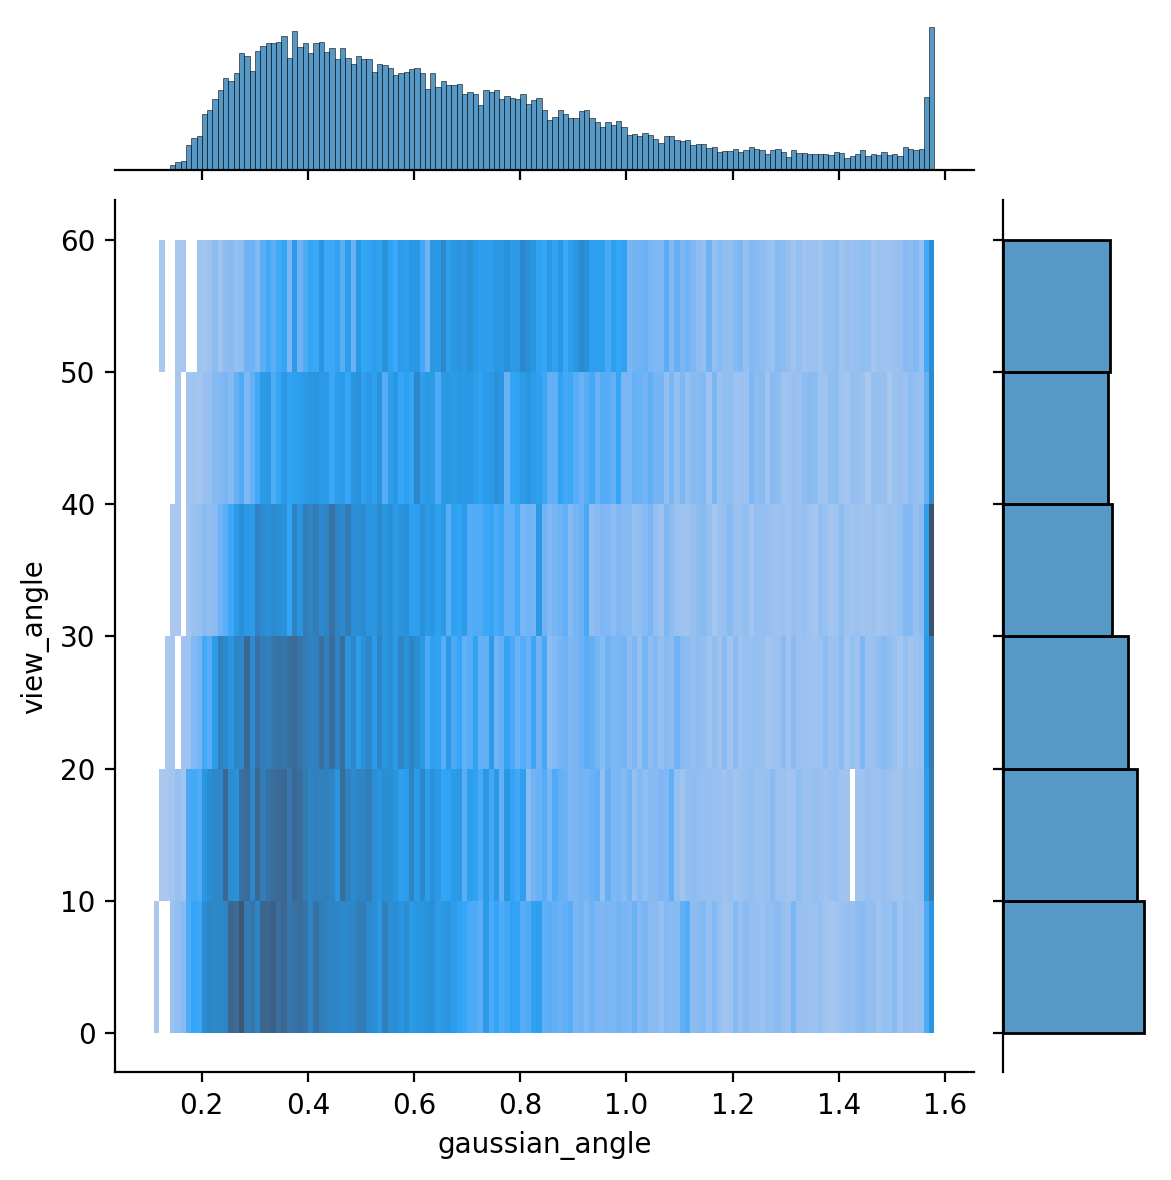

In [ ]:
p = sns.jointplot(
    ellipse_matches,
    x = 'gaussian_angle',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

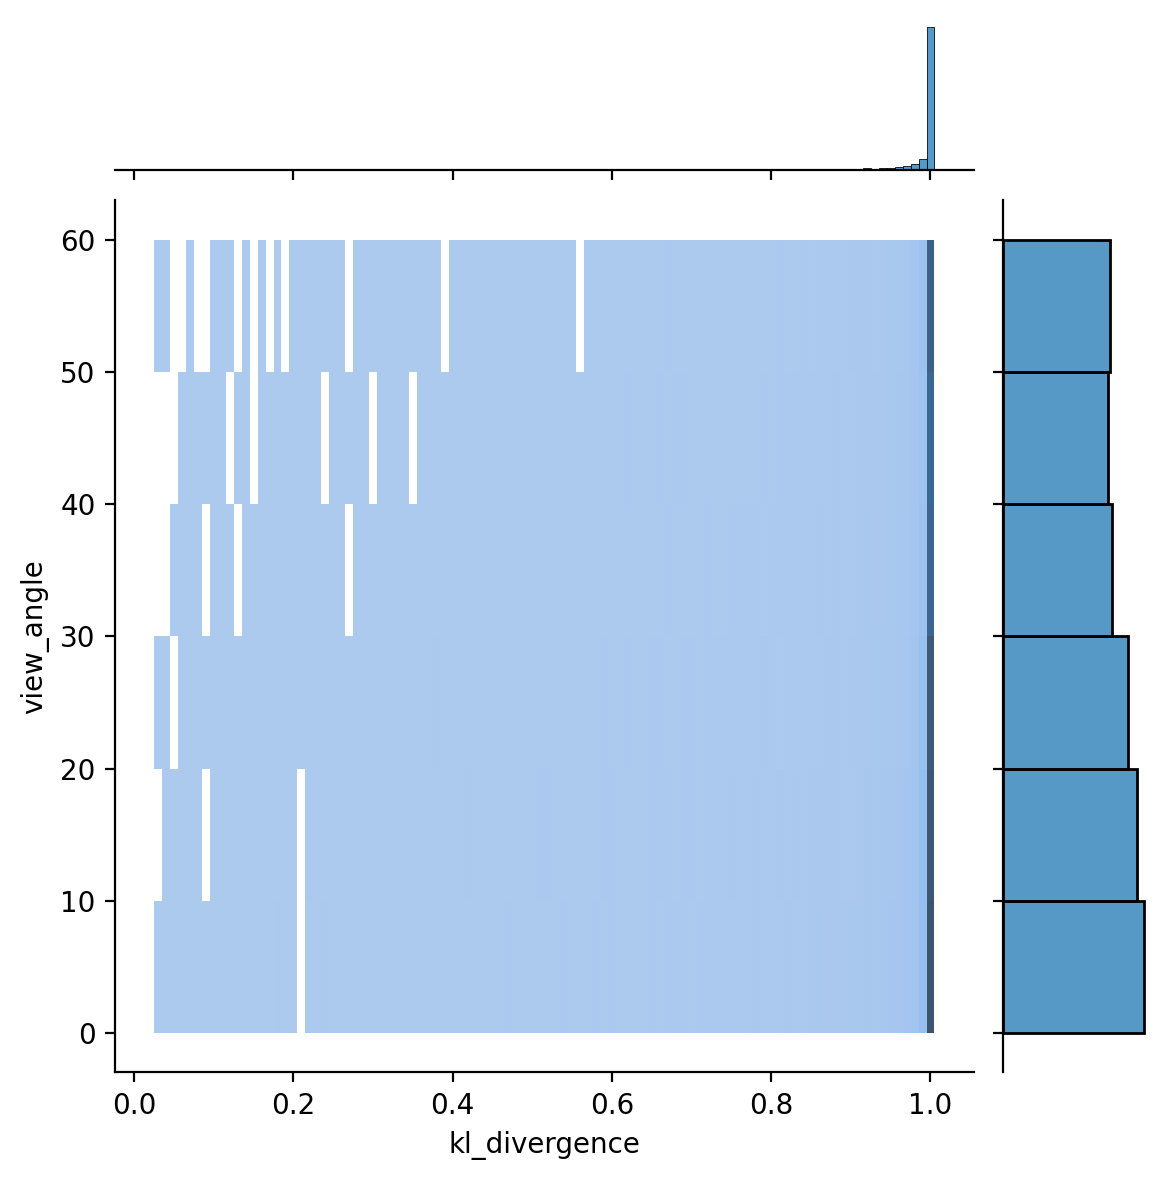

In [ ]:
p = sns.jointplot(
    ellipse_matches,
    x = 'kl_divergence',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

ValueError: Could not interpret value `view_angle` for parameter `y`

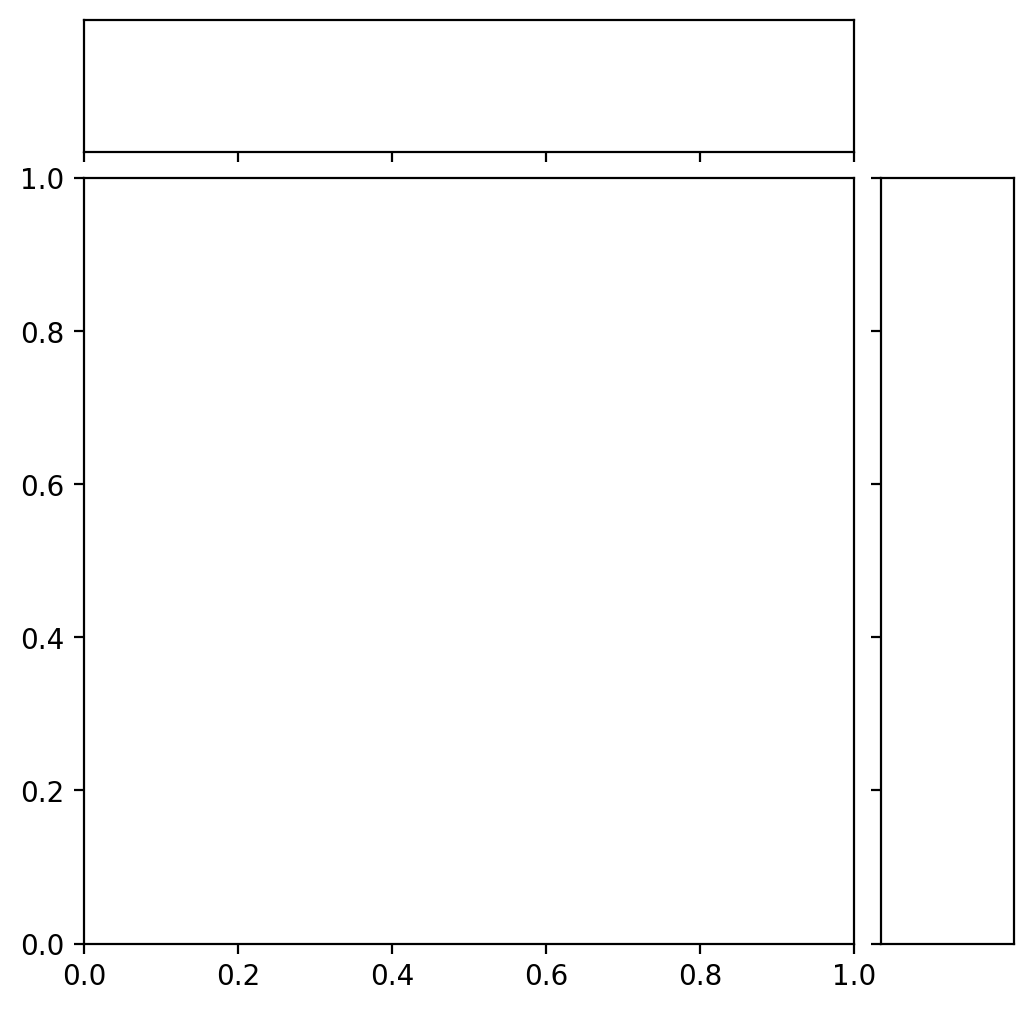

In [33]:
p = sns.jointplot(
    ellipse_matches,
    x = 'IoU',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

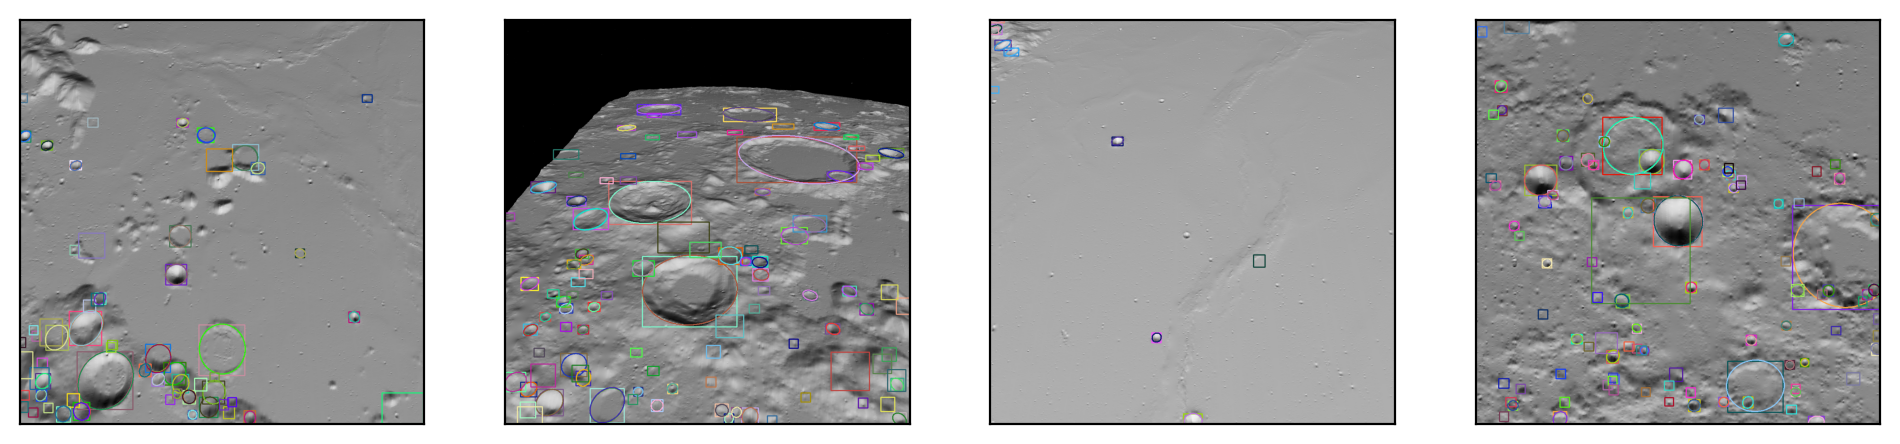

In [114]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for bbox, ellipse in zip( predictions[pred_index]['boxes'], predictions[pred_index]['ellipse_sparse'] ):
        color = ( np.random.rand(), np.random.rand(), np.random.rand() )
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
        
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] / 2 ), int( ellipse[3] / 2 ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )
    
    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()